## Part 1 - Questions to text and lectures.

### A) Segal and Heer paper

* **What is the Oxford English Dictionary's defintion of a narrative?**

“an account of a series of events, facts, etc., given in order and with the establishing of connections between them.”


* **What is your favorite visualization among the examples in section 3? Explain why in a few words.**

Figure 2 comparing budget forecasts with reality is a great visualization because even though its simple, it elegantly conveys the narrative through usage of the martini glass structure. The visualiztion shows a good amount of information and the layout is consitent ensuring that reader doesn't get disoriented and is able to understand the story. Finally the visualization uses a tacit tutorial to ensure that the reader knows which interactions are possible.

* **What's the point of Figure 7?**

Figure 7 shows an analysis of tactics used for visual narrative as well as narrative structures used acros mutliple genres of visualization. The figure highlights trends in specific genres, it showcases which strategies are commonly used as well as which are under utilized. 

* **Use Figure 7 to find the most common design choice within each category for the Visual narrative and Narrative structure**

The most common choices are shown in the following table:

| Visual Structuring        | Highlighting        | Transition Guidance | Ordering           | Interactivity                  | Messaging           |
|---------------------------|---------------------|---------------------|--------------------|--------------------------------|---------------------|
| Consitent Visual Platform | Feature Distinction | Object Continuity   | User Directed Path | Filtering / Selection / Search | Caption / Headlines |


* Visual Narrative

    The most common choice for visual structuring is a consistent platform. Feature distinction is by far the most popular highlighting strategy. Object continuety is the most used transition gudiance strategy, closely followed by animated transition s as well as familiar objects. 


* Narrative Structure

    User directed path is by far the most used Ordering strategy. Filtering/selection/search is almost always used for interactivity. Captions/Headlines are used very frequently closly followed by annotations.



* **Check out Figure 8 and section 4.3. What is your favorite genre of narrative visualization? Why? What is your least favorite genre? Why?**

Slide show is great for narrative visualization because it can utilize a vast amount of strategies in regards of both visual narrative as well as narrative structure. It can utilize interactivity well, letting the user explore at their own pace and to the desired extend, while making sure the narrative is pressentend in the intended order from start to end.

Magazine style is the most limiting medium in regards of which narrative strategies can be utiliez and is therfore the least interresting.

### B) Explanatory data visualization

* **What are the three key elements to keep in mind when you design an explanatory visualization?**

    * The first key point is to ask yourself, what results you want to communicate to the audience. 
    * The second keypoint is to allow exploration by utilizing user interactions in order to further engage the audience.
    * The third keypoint is you should know the audience and design the visualization accordingly.

* **In the video I talk about (1) overview first, (2) zoom and filter, (3) details on demand.**

    * **Go online and find a visualization that follows these principles (don't use one from the video).**
    
    <img src="https://magei.dk/wp-content/uploads/2020/03/FacebookVisualization.png" alt="Drawing" style="width: 550px;"/>
   
   The visualization is a Slide show showing how Facebook compares to other tech IPO's. It can be viewed in the following link:
    https://archive.nytimes.com/www.nytimes.com/interactive/2012/05/17/business/dealbook/how-the-facebook-offering-compares.html?ref=technology
    

* **Explain how it achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.**
    
     **(1)** On the first slide an overview is given of previous IPO's to set the scene. **(2)** On the following slides zoom is used to change the users perspective. **(3)** At all times its possible to hower over the companies to get details on demand. It is also possible to search for a specific company.
    
    
* **Explain in your own words: How is explanatory data analysis different from exploratory data analysis?**

Explanatory data analysis is used to communicate results from a dataset to an audience, which means that the way the results are visualized is of utmost importance. Explanatory data analysis is all about creating a narrative through varius visualization strategies, that is engaging for the user. 
On the other hand exploratory data analysis is usefull for figuring out what narrative (if any) the dataset is able to tell.  

# Part 2 - Random forest and weather

In [1]:
import pprint
import folium
import pandas as pd
import numpy as np
import sklearn
import datetime as dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Predicting without weather data

In [2]:
police_data = pd.read_csv("../../police_data.csv")

In [3]:
police_data['Time'] = pd.to_datetime(police_data['Time'],format="%H:%M")
police_data['Date'] = pd.to_datetime(police_data['Date'],format="%m/%d/%Y")

In [4]:
police_data = police_data[(police_data['Date'] > '2012-10-01') & (police_data['Date'] < '2017-10-27')]

new_pd = police_data[['Category', 'Date','Time','DayOfWeek','PdDistrict']]
new_pd['Hour'] = new_pd['Time'].dt.hour
new_pd['Month'] = new_pd['Date'].dt.month
new_pd['Hour_of_week'] = new_pd['Date'].dt.dayofweek * 24 + (new_pd['Hour'] + 1)
new_pd['DayOfWeek'] = new_pd['Date'].dt.dayofweek

# Categories to use, framing the data

We define two categories, burglary and fraud. These are chosen because we hypothesize that burglaries are very impacted by weather, while fraud is not, and we want to see if weather have any effect on these crimes.

We use balanced datasets, with 10000 samples in each. We chose balanced simply because otherwise we might well have way too many burglary incidents compared to fraud, or the other way around, which would skew our model and ultimately impact later predictions. 

We then combine the datasets to one dataframe, which we then again split into training and testing sets.

In [5]:
burglaries = new_pd[(new_pd['Category'] == 'BURGLARY')]
fraud = new_pd[(new_pd['Category'] == 'FRAUD')]

balanced_burglaries = burglaries.sample(10000, random_state=1)
balanced_fraud = fraud.sample(10000, random_state=1)
combined_set = pd.concat([balanced_burglaries,balanced_fraud],axis=0)
combined_set['PdDistrict'] = pd.factorize(combined_set['PdDistrict'])[0]

In [6]:
train, test = train_test_split(combined_set, test_size=0.2)

We drop the time and date columns.

In [7]:
X_train = train.drop(columns=['Category','Time','Date'])
y_train = train['Category']

X_test = test.drop(columns=['Category','Time','Date'])
y_test = test['Category']

We define a small function for testing models.

In [8]:
def test_model(model):
    model.fit(X_train, y_train)
    print(model.score(X_test,y_test))

# Preparing the models

We define two distinct random forest classifiers, base_rfc, which represents a default instance of the random forest classfier that SKLearn provides, and later on we define **improved_rfc**. On improved_rfc we perform a Randomized Search for best hyperparameters, so as to find the 'best' parameters for our model, without having the manually adjust these. **Beware that testing for parameters takes a while**, so we've included the results of the testing below in the dict 'dbest_params'. No need to actually perform the testing on the readers part. 

In [9]:
base_rfc = RandomForestClassifier()
test_model(base_rfc)

0.58725


We define the parameters and different values to test with. These are chosen with speed in mind, as testing for parameters takes a while. We have tried to cover most sensible values. 

In [10]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [1,5,20,50,100,200,500]
min_samples_leaf = [1,5,20,50,100,200,500]
bootstrap = [True, False]

In [11]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [12]:
rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [13]:
best_params = {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 2000, 'min_samples_split': 100, 'min_samples_leaf': 20, 'bootstrap': True}

In [14]:
dbest_params = {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1000, 'min_samples_split': 100, 'min_samples_leaf': 20, 'bootstrap': True}

In [15]:
improved_rfc = RandomForestClassifier()
improved_rfc.set_params(**best_params);

In [16]:
test_model(improved_rfc)

0.63975


# Did testing for hyperparameters help?

Well yes, it did. base_rfc has accuracy of about 0.59 - 0.60, while our improved model is around 0.64. 
A small improvement but anything counts!

Now we are interesting in testing for features, or more accurately, testing for how many features we ideally use.
For this we use SKLearns Recursive feature elimination with cross-validation (or, RFECV). This way we contiously fit our model and remove a feature at each step, and cross validate along the way. The end result is a model fitted with the best amount of features, that also avoids overfitting due to cross-validation.
The impact on accuracy, however, is barely noticable and remains about 0.64. 

In [17]:
rfecv_pre = RFECV(estimator = improved_rfc, step=1, cv=StratifiedKFold(2),scoring='accuracy')

In [18]:
rfecv_pre.fit(X_train,y_train)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=20,
                                       min_samples_split=100,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=2000, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

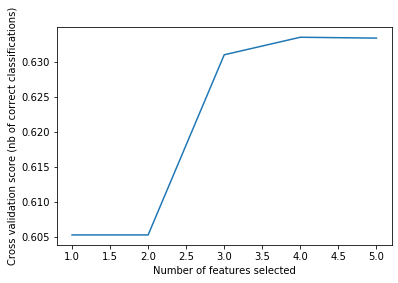

In [19]:
rfecv_pre.score(X_test, y_test)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_pre.grid_scores_) + 1), rfecv_pre.grid_scores_)
plt.show()

In [20]:
rfecv_pre.score(X_test, y_test)

0.64325

# With weather

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [22]:
weather_data = pd.read_csv("../../weather_data.csv")
weather_data['date'] = pd.to_datetime(weather_data['date'],infer_datetime_format="%Y/%m/%d",format="%d/%m/%Y")
weather_data.dropna()
weather_data['date'] = weather_data['date'].dt.tz_localize(None)
weather_data['hour'] = weather_data['date'].dt.hour
weather_data['date'] = weather_data['date'].dt.date

new_pd['Date'] = new_pd['Date'].dt.date

We merge the two datasets and repeat the steps in the previous section.

In [23]:
new_df = pd.merge(new_pd,weather_data,how='left',left_on=['Date','Hour'], right_on=['date','hour'])
new_df = new_df.dropna()

In [24]:
burglaries = new_df[(new_df['Category'] == 'BURGLARY')]
fraud = new_df[(new_df['Category'] == 'FRAUD')]

The features 'weather' and 'PdDistrict' is again factorized to allow the classfier to utilize them.

In [25]:
balanced_burglaries = burglaries.sample(10000, random_state=1)
balanced_fraud = fraud.sample(10000, random_state=1)
combined_set = pd.concat([balanced_burglaries,balanced_fraud],axis=0)
combined_set['PdDistrict'] = pd.factorize(combined_set['PdDistrict'])[0]
combined_set['weather'] = pd.factorize(combined_set['weather'])[0]

In [26]:
train_weather, test_weather = train_test_split(combined_set, test_size=0.2)

In [27]:
X_train_weather = train_weather.drop(columns=['Category','Time','Date','date'])
y_train_weather = train_weather['Category']

X_test_weather = test_weather.drop(columns=['Category','Time','Date','date'])
y_test_weather = test_weather['Category']

# What features to use?

Instead of removing features we think may or may not work in regards to the weather, we once again turn to RFECV. 
Adding weather data means that we now have 11 features total, so performing the RFECV now takes a little longer. Again, for the readers sake, we've included the results below so no need to fit the RFECV.  

In [28]:
rfecv = RFECV(estimator = improved_rfc, step=1, cv=StratifiedKFold(2),scoring='accuracy')

In [29]:
rfecv.fit(X_train_weather,y_train_weather)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=20,
                                       min_samples_split=100,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=2000, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Below is a small plot of how our accuracy changes according to features used. 5 is optimal and adding more lowers the accuracy.

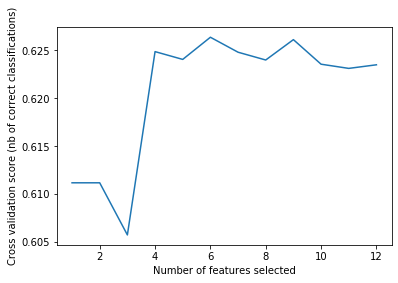

In [30]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [31]:
rfecv.score(X_test_weather,y_test_weather)

0.63425

In [32]:
improved_rfc.fit(X_train_weather, y_train_weather)
improved_rfc.score(X_test_weather, y_test_weather)

0.62625

In [33]:
base_rfc.fit(X_train_weather, y_train_weather)
base_rfc.score(X_test_weather, y_test_weather)

0.60875

# Final results

To avoid having the user perform RFECV, here are the final results:

## Crime-data without weather:

Naive Random Forest Classifer (without finding best hyperparameters or performing RFECV:
~ 0.59

w. best hyperparameters:
~ 0.64

w. best hyperparameters and best features:
~ 0.64

## Crime-data with weather:

Naive Random Forest Classifer (without finding best hyperparameters or performing RFECV:
~ 0.6

w. best hyperparameters:
~ 0.62

w. best hyperparameters and best features:
~ 0.63

As it turns out, adding weather data to our original crime dataset did not improve accuracy. We can now make a somewhat educated guess and say that neither burglary nor fraud depends severely on the current weather situation.

But, we can predict what type of crime will take base on some relevant features, with about 64% accuracy. This is by no means perfect, but it's better than purely guessing.

In [34]:
ranks = rfecv.ranking_

In [35]:
features = X_test_weather.columns.to_numpy()

## What were the most significant features?

Here's the ranking, with lower being better. DayOfWeek scores worst and has little to no positive impact. Same goes for weather, wind speed and month. Temperature turned out to be relatively important, so did hour, police district and , surprisingly, wind direction.

* Ranking of DayOfWeek : 8
* Ranking of PdDistrict : 1
* Ranking of Hour : 1
* Ranking of Month : 5
* Ranking of Hour_of_week : 1
* Ranking of temperature : 1
* Ranking of humidity : 3
* Ranking of weather : 6
* Ranking of wind_speed : 7
* Ranking of wind_direction : 2
* Ranking of pressure : 4
* Ranking of hour : 1


In [36]:
for i in range(len(ranks)):
    print("Ranking of " + features[i] + " : " + str(ranks[i]))

Ranking of DayOfWeek : 6
Ranking of PdDistrict : 1
Ranking of Hour : 1
Ranking of Month : 4
Ranking of Hour_of_week : 1
Ranking of temperature : 1
Ranking of humidity : 2
Ranking of weather : 5
Ranking of wind_speed : 7
Ranking of wind_direction : 1
Ranking of pressure : 3
Ranking of hour : 1


# Part 3 - Data visualization

First thing we need to do is import the data and convert it to the correct format.

We choose to only look at the focuscrimes.<br>
Then we want the date data to be easily accesible so we extract all the relevant information and put it in seperate collumns.

In [37]:
import numpy as np
import pandas as pd
from datetime import date

focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
police_data_all = pd.read_csv('../../police_data.csv')

police_data = police_data_all.where(police_data_all.Category.isin(focuscrimes))

police_data['Date'] = pd.to_datetime(police_data['Date'], format="%m/%d/%Y")
police_data['Time'] = pd.to_datetime(police_data['Time'], format="%H:%M")
police_data['Year'] = police_data['Date'].dt.year
police_data['Month'] = police_data['Date'].dt.month
police_data['Hour'] = police_data['Time'].dt.hour
police_data['Hour_of_week'] = police_data['Date'].dt.dayofweek * 24 + (police_data['Hour'] + 1)
police_data['Day'] = police_data['Date'].dt.day
police_data['Minute'] = police_data['Time'].dt.minute


Now with the data imported we normalize it so it better compares between different crimetypes.

We do this by splitting every category up into 24 chunks of 1 hour, and the dividing each chunk by the total amount of that crime.

This results in a value between 0 and 1 that describes the percentage of a given crime in that time interval.<br>
The results can be seen below.

In [38]:
crime_hour_norm_df = pd.DataFrame()
crime_hour_norm_df.insert(0, 'Hour', np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])) 
for i, category in enumerate(focuscrimes):
    df = police_data[police_data.Category == category]
    df_hour = df['Category'].groupby(df['Hour']).count()
    
    #normalize
    df_hour= df_hour/df['Category'].count()
    
    #insert normalized data into dataframe
    crime_hour_norm_df.insert(i+1, category, df_hour) 
    

crime_hour_norm_df.head()

,Hour,TRESPASS,PROSTITUTION,ASSAULT,LARCENY/THEFT,BURGLARY,DRUG/NARCOTIC,VEHICLE THEFT,WEAPON LAWS,ROBBERY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUNKENNESS,VANDALISM,STOLEN PROPERTY
0,0,0.029565,0.082450,0.055754,0.039790,0.038190,0.031556,0.037669,0.051902,0.053484,0.052291,0.126234,0.084470,0.056299,0.047094
1,1,0.020669,0.063948,0.047541,0.024538,0.024764,0.019251,0.025710,0.038275,0.054845,0.038347,0.114951,0.079890,0.039308,0.033134
2,2,0.023292,0.047602,0.043088,0.015983,0.026687,0.015531,0.020355,0.034137,0.057207,0.034363,0.115480,0.067576,0.037076,0.027752
3,3,0.019024,0.032753,0.021999,0.010043,0.027495,0.010533,0.012662,0.021139,0.034421,0.021514,0.051128,0.026359,0.024970,0.021529
4,4,0.014140,0.028322,0.013981,0.006533,0.024393,0.007682,0.009779,0.014257,0.022303,0.015936,0.019217,0.013536,0.016733,0.019174


Now with the data ready we just need to displat it in the Bokeh plot.

This is mostly just fiddling with a lot of settings, <br>
in colors we store all the colors for the bars.<br>
In items we store the different crimes to create a legend later, notice how we link it to the bars in line 23 items.append((i, [bar[i]])) <br>

Most of the settings make sense on their own, but some interesting ones that we played with was: <br>
* visible, we decided to hide all the graphs except for one to begin with, since you usually only want to compare two at a time, and turning everything off is tedious.
* fill_alpha, this is the transparency of the bars and we needed to set it to something lower that 1 so that the bars would read through eachother.
* toolbar_location, we decided to hide the main toolbar since it didn't add much functionality and just cluttered up the plot.

In [39]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import FactorRange
from bokeh.plotting import figure
from bokeh.models import Legend

output_notebook() # for outputting to notebook
source = ColumnDataSource(crime_hour_norm_df) # data importing
colors = ["#a83232", "#a86932", "#a8a232", "#7da832", "#32a83c", "#32a87f", "#3283a8","#324aa8", "#5d32a8", "#9432a8", "#a83273", "#a83248", "#b59399", "#2e292a"]

hours = []
for i in range(24):
    hours.append(str(i))

p = figure(x_range = FactorRange(factors=hours), plot_height=400, plot_width=900, title="Normalized crime rate over a day", 
           toolbar_location=None)
items=[]
bar ={} # to store vbars

for indx,i in enumerate(focuscrimes):
    
    bar[i] = p.vbar(x='Hour',  top=i, source= source, visible = False, width= 0.8, color =colors[indx], fill_alpha =0.6) 
    items.append((i, [bar[i]]))
    
#p.legend.click_policy="hide" ### assigns the click policy (you can try to use ''hide'
#p.legend.location = 'top_left'

legend = Legend(items=items, location=(0,0))
legend.click_policy="hide"

p.add_layout(legend, 'left')
p.xaxis.axis_label = "Hour of day"
p.yaxis.axis_label = "Percentage of crime"

bar['TRESPASS'].visible = True #we start with weapons laws just to display something

show(p) #displays your plot




Loading BokehJS ...

Heres a gif of it!
<img src="https://magei.dk/wp-content/uploads/2020/03/LevelEditor.gif" alt="Drawing" style="width: 550px;"/>